In [ ]:
import torch
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms
from sklearn.model_selection import train_test_split


class DataLoaderHelper:
    def __init__(self, train_data_dir,test_data_dir, input_size, batch_size, augmentation):
        self.data_dir = train_data_dir
        self.test_dir = test_data_dir
        self.batch_size = batch_size
        self.augmentation = augmentation
        self.input_size = input_size  # tuple like (224, 224)

        self.transform = self.get_transform()
        self.train_data, self.val_data = self.load_train_val_data()
        self.test_data = self.load_test_data()

    def get_transform(self):
        if self.augmentation:
            transforms_list = [
                transforms.RandomResizedCrop(self.input_size),
                transforms.RandomHorizontalFlip(),
                transforms.RandomRotation(30),
                transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
                transforms.ToTensor(),
            ]
        else:
            transforms_list = [
                transforms.Resize(self.input_size),
                transforms.ToTensor(),
            ]

        transforms_list.append(
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
        )
        return transforms.Compose(transforms_list)

    def load_train_val_data(self):
        full_dataset = datasets.ImageFolder(root=self.data_dir, transform=self.transform)
        total_size = len(full_dataset)
        indices = list(range(total_size))

        train_idx, val_idx = train_test_split(indices, test_size=0.2, random_state=42, shuffle=True)

        # print(f"Total: {total_size} | Train: {len(train_idx)} | Val: {len(val_idx)}")
        return Subset(full_dataset, train_idx), Subset(full_dataset, val_idx)

    def load_test_data(self):
        return datasets.ImageFolder(root=self.test_dir, transform=self.transform)

    def get_dataloaders(self):
        train_loader = DataLoader(self.train_data, batch_size=self.batch_size,
                                  shuffle=True, num_workers=2, pin_memory=True)
        val_loader = DataLoader(self.val_data, batch_size=self.batch_size,
                                shuffle=False, num_workers=2, pin_memory=True)

        test_loader = DataLoader(self.test_data, batch_size=self.batch_size,
                                     shuffle=True, num_workers=2, pin_memory=True)
      

        return train_loader, val_loader, test_loader

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class FlexibleCNN(nn.Module):
    def __init__(self, num_filters, filter_sizes,dropout,activation, batch_norm, input_size,fc_hidden_sizes,num_classes):
        #Initialize the pytorch neural network..
        super(FlexibleCNN, self).__init__()

        self.dropout = dropout
        self.activation = activation
        self.batch_norm = batch_norm
        self.num_filters = num_filters # list
        self.filter_sizes = filter_sizes #list
        self.input_size=input_size #tuple
        self.fc_hidden_sizes=fc_hidden_sizes #list
        self.num_classes=num_classes
        self.flatten = nn.Flatten() 

        #Call the functions to create Convolution layers and Fully Connected layers
        # self.conv_layers = self.create_conv_layers()
        # self.fc_layers = self.create_fc_layers()
        self.conv_layers = nn.Sequential(*self.create_conv_layers())
        self.fc_layers = nn.Sequential(*self.create_fc_layers())
             

    def create_conv_layers(self):
        layers = []
        channels = 3  #RGB 

        for idx, (filters, size) in enumerate(zip(self.num_filters, self.filter_sizes)):

            #For each layer we are adding the below there.

            #Number of filters and filter size. 
            layers.append(nn.Conv2d(channels, filters, size,stride=1, padding=0))

            # if self.batch_norm:
            #     layers.append(nn.BatchNorm2d(filters))

            if self.activation == 'relu':
                layers.append(nn.ReLU())
            elif self.activation == 'elu':
                layers.append(nn.ELU())
            elif self.activation == 'selu':
                layers.append(nn.SELU())
            elif self.activation == 'silu':
                layers.append(nn.SiLU())
            elif self.activation == 'gelu':
                layers.append(nn.GELU())
            else:
                layers.append(nn.Mish())

            # You can add new activation functions If you want

            layers.append(nn.MaxPool2d(2))

            if self.batch_norm:
                layers.append(nn.BatchNorm2d(filters))
            
            channels = filters  


        # return nn.Sequential(*layers)
        return layers

    def create_fc_layers(self):
        # Calculate flattened size from conv layers
        flattened_size = self.output_conv_layers()  

        layers = []
        features = flattened_size

        for hidden_size in self.fc_hidden_sizes:
            # Add linear layer
            layers.append(nn.Linear(features, hidden_size))

            # if self.batch_norm:
            #     layers.append(nn.BatchNorm1d(hidden_size))
            
            
            # Add activation function
            if self.activation == 'relu':
                layers.append(nn.ReLU())
            elif self.activation == 'elu':
                layers.append(nn.ELU())
            elif self.activation == 'selu':
                layers.append(nn.SELU())
            elif self.activation == 'silu':
                layers.append(nn.SiLU())
            elif self.activation == 'gelu':
                layers.append(nn.GELU())
            else:
                layers.append(nn.Mish())
            
            # Add dropout
            layers.append(nn.Dropout(self.dropout))
            
            features = hidden_size

        # Final output layer (no activation, no batch norm)
        layers.append(nn.Linear(features, self.num_classes))

        # return nn.Sequential(*layers)
        return layers
    


    def output_conv_layers(self):
        with torch.no_grad():
            dummy_input = torch.zeros(1, 3, *self.input_size)
            conv_output = self.conv_layers(dummy_input)
            return conv_output.view(1, -1).size(1) 


    def forward(self, x):
        x = self.conv_layers(x)
        x= self.flatten(x)
        x = self.fc_layers(x)
        return x


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from datetime import datetime
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import wandb

class Trainer:
    def __init__(self, model, train_loader, val_loader,test_loader, optimizer_name, learning_rate, num_epochs,weight_decay):
        # Set device
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        # self.model=torch.nn.DataParallel(model,device_ids = [0,1]).to(self.device)
        self.model = model.to(self.device)
        
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.test_loader=test_loader
        self.num_epochs = num_epochs
        self.weight_decay= weight_decay
        self.learning_rate=learning_rate
        self.train_loss_history = []
        self.val_loss_history = []
        self.train_acc_history = []
        self.val_acc_history = []
        
        # Initialize optimizer
        if optimizer_name.lower() == 'adam':
            self.optimizer = optim.Adam(model.parameters(), lr=self.learning_rate,weight_decay=self.weight_decay)
        elif optimizer_name.lower() == 'nadam':
            self.optimizer = optim.NAdam(model.parameters(), lr=self.learning_rate, weight_decay=self.weight_decay)
        elif optimizer_name.lower() == 'rmsprop':
            self.optimizer = optim.RMSprop(model.parameters(), lr=self.learning_rate,weight_decay=self.weight_decay)
        else:
            raise ValueError(f"Unsupported optimizer: {optimizer_name}")
            
        self.criterion = nn.CrossEntropyLoss()
        
    def train_epoch(self):
        #Initialize the training requirements that we have defined in model
        self.model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        for images, labels in tqdm(self.train_loader, desc="Training"):
            images, labels = images.to(self.device), labels.to(self.device)
            
            self.optimizer.zero_grad()
            outputs = self.model(images)
            loss = self.criterion(outputs, labels)
            loss.backward()
            #weight update
            self.optimizer.step()
            
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
        epoch_loss = running_loss / len(self.train_loader)
        epoch_acc = correct / total
        return epoch_loss, epoch_acc
    
    def validate(self):
        self.model.eval()
        running_loss = 0.0
        correct = 0
        total = 0
        
        with torch.no_grad():
            for images, labels in tqdm(self.val_loader, desc="Validating"):
                images, labels = images.to(self.device), labels.to(self.device)
                outputs = self.model(images)
                loss = self.criterion(outputs, labels)
                
                running_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                
        epoch_loss = running_loss / len(self.val_loader)
        epoch_acc = correct / total
        return epoch_loss, epoch_acc
    
    def train(self):
        for epoch in range(self.num_epochs):
            print(f"\nEpoch {epoch+1}/{self.num_epochs}")
            
            train_loss, train_acc = self.train_epoch()
            val_loss, val_acc = self.validate()
            
            # Store history for analysis
            self.train_loss_history.append(train_loss)
            self.val_loss_history.append(val_loss)
            self.train_acc_history.append(train_acc)
            self.val_acc_history.append(val_acc)
            
            print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc*100:.4f}")
            print(f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc*100:.4f}")
            torch.cuda.empty_cache() 

    def confusion_matrix(self,count=3,Capture_Img=True,plot=True):
        class_names=["Amphibia", "Animalia", "Arachnida", "Aves", "Fungi", "Insecta", "Mammalia", "Mollusca", "Plantae", "Reptilia"]
    
        confusion_matrix = np.zeros((len(class_names), len(class_names)), dtype=int)
    
        self.model.eval()
        correct = 0
        total = 0
            
        captured_samples = [[] for _ in range(len(class_names))] 
  
        class_to_idx = {name: idx for idx, name in enumerate(class_names)} 

        

        
        with torch.no_grad():
            for images, labels in tqdm(self.test_loader, desc="testing"):
                images, labels = images.to(self.device), labels.to(self.device)
                outputs = self.model(images)
        
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                
                # Updating Confusion Matrix
                for true, predict in zip(labels.cpu(), predicted.cpu()):
                  confusion_matrix[true,predict] += 1

                if Capture_Img:
                    for i in range(images.size(0)):
                        true_label = labels[i].item()
                        class_idx = class_to_idx[class_names[true_label]] 
                        if len(captured_samples[class_idx]) < count:
                            img = images[i].cpu().numpy()
                            pred_label = predicted[i].item()
                            captured_samples[class_idx].append((img, true_label, pred_label))

        Acc=correct/total

        print(f"Test Acc: {Acc*100:.4f}")
        if plot:
            plt.figure(figsize=(10, 7))
            sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap="Greens", xticklabels=class_names, yticklabels=class_names)
            plt.xlabel("Predicted Label")
            plt.ylabel("Actual Label")   
            plt.title("Confusion Matrix")
            plt.show()
        else:
            plt.figure(figsize=(10, 7))
            sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap="Greens", xticklabels=class_names, yticklabels=class_names)
            plt.xlabel("Actual Label")
            plt.ylabel("Predicted Label")
            plt.title("Confusion Matrix")
            Img_name="confusion_matrix.png"
            plt.savefig(Img_name)
            plt.close()
            wandb.log({"confusion_matrix": wandb.Image(Img_name)})

        if Capture_Img and any(captured_samples):
            rows = len(class_names)
            cols = count
            fig, axes = plt.subplots(rows, cols, figsize=(cols*3, rows*3))
            
            for row_idx, class_samples in enumerate(captured_samples):
                for col_idx in range(cols):
                    ax = axes[row_idx, col_idx]
                    ax.axis('off')
                    if col_idx < len(class_samples):
                        img, true, pred = class_samples[col_idx]
                        # Unnormalize and transpose
                        img = img.transpose(1, 2, 0)
                        img = (img * np.array([0.229, 0.224, 0.225])) + np.array([0.485, 0.456, 0.406])
                        img = np.clip(img, 0, 1)
                        ax.imshow(img)
                        ax.set_title(f"True: {class_names[true]}\nPred: {class_names[pred]}")
            
            plt.tight_layout()
            
            if plot:
                plt.show()
            else:
                # Save the figure explicitly
                Img_name = "predictions.png"
                fig.savefig(Img_name, bbox_inches='tight', dpi=300, pad_inches=0.1)
                plt.close(fig)  # Close the specific figure
                wandb.log({"predictions": wandb.Image(Img_name)})
            
    
    
        return confusion_matrix
            
   

In [4]:
!pip install wandb


In [ ]:
import wandb
wandb.login()
# If you are running this file in kaggle pass   key='Your login key' i.e wandb.login(key= '')


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: cs24m042 (cs24m042-iit-madras-foundation) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True


Epoch 1/10


Validating: 100%|██████████| 63/63 [00:12<00:00,  5.11it/s]


Train Loss: 2.0796 | Train Acc: 25.5407
Val Loss: 2.0775 | Val Acc: 27.6000

Epoch 2/10


Validating: 100%|██████████| 63/63 [00:12<00:00,  5.18it/s]


Train Loss: 1.8798 | Train Acc: 33.4792
Val Loss: 1.8865 | Val Acc: 35.1000

Epoch 3/10


Validating: 100%|██████████| 63/63 [00:12<00:00,  5.10it/s]


Train Loss: 1.6734 | Train Acc: 41.6177
Val Loss: 1.8661 | Val Acc: 36.4000

Epoch 4/10


Validating: 100%|██████████| 63/63 [00:12<00:00,  5.17it/s]


Train Loss: 1.3810 | Train Acc: 53.6192
Val Loss: 1.9244 | Val Acc: 33.6000

Epoch 5/10


Validating: 100%|██████████| 63/63 [00:12<00:00,  4.99it/s]


Train Loss: 0.9719 | Train Acc: 70.3338
Val Loss: 1.8960 | Val Acc: 37.9000

Epoch 6/10


Validating: 100%|██████████| 63/63 [00:12<00:00,  5.16it/s]


Train Loss: 0.4851 | Train Acc: 87.9360
Val Loss: 2.0343 | Val Acc: 35.7000

Epoch 7/10


Validating: 100%|██████████| 63/63 [00:12<00:00,  5.13it/s]


Train Loss: 0.1813 | Train Acc: 96.6871
Val Loss: 2.1905 | Val Acc: 35.1500

Epoch 8/10


Validating: 100%|██████████| 63/63 [00:12<00:00,  5.22it/s]


Train Loss: 0.0652 | Train Acc: 99.0874
Val Loss: 2.2109 | Val Acc: 34.7000

Epoch 9/10


Validating: 100%|██████████| 63/63 [00:12<00:00,  5.15it/s]


Train Loss: 0.0296 | Train Acc: 99.7000
Val Loss: 2.2205 | Val Acc: 37.0500

Epoch 10/10


Validating: 100%|██████████| 63/63 [00:13<00:00,  4.76it/s]


Train Loss: 0.0126 | Train Acc: 99.9375
Val Loss: 2.3129 | Val Acc: 35.6500


testing: 100%|██████████| 63/63 [00:13<00:00,  4.81it/s]


Test Acc: 37.4500


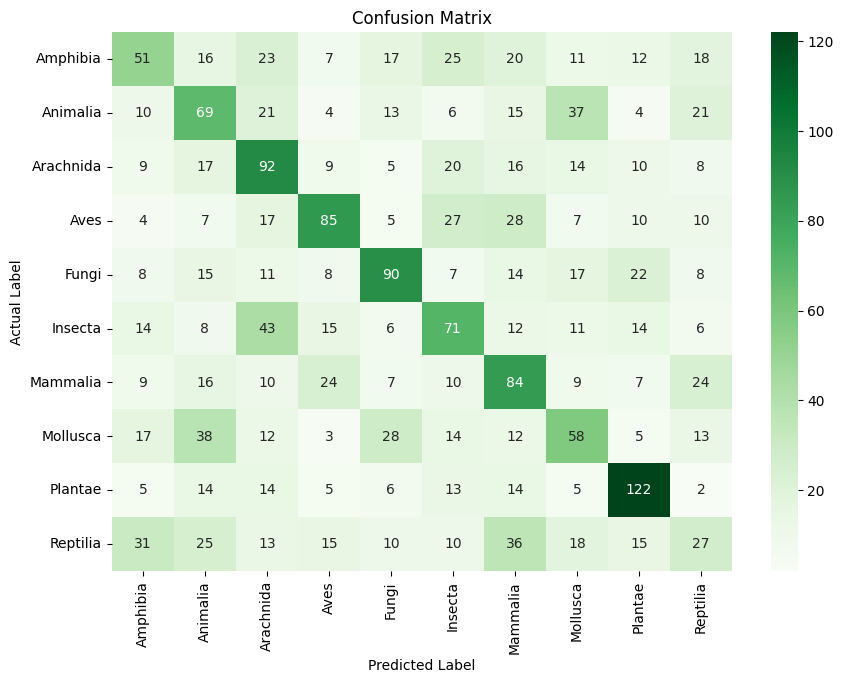

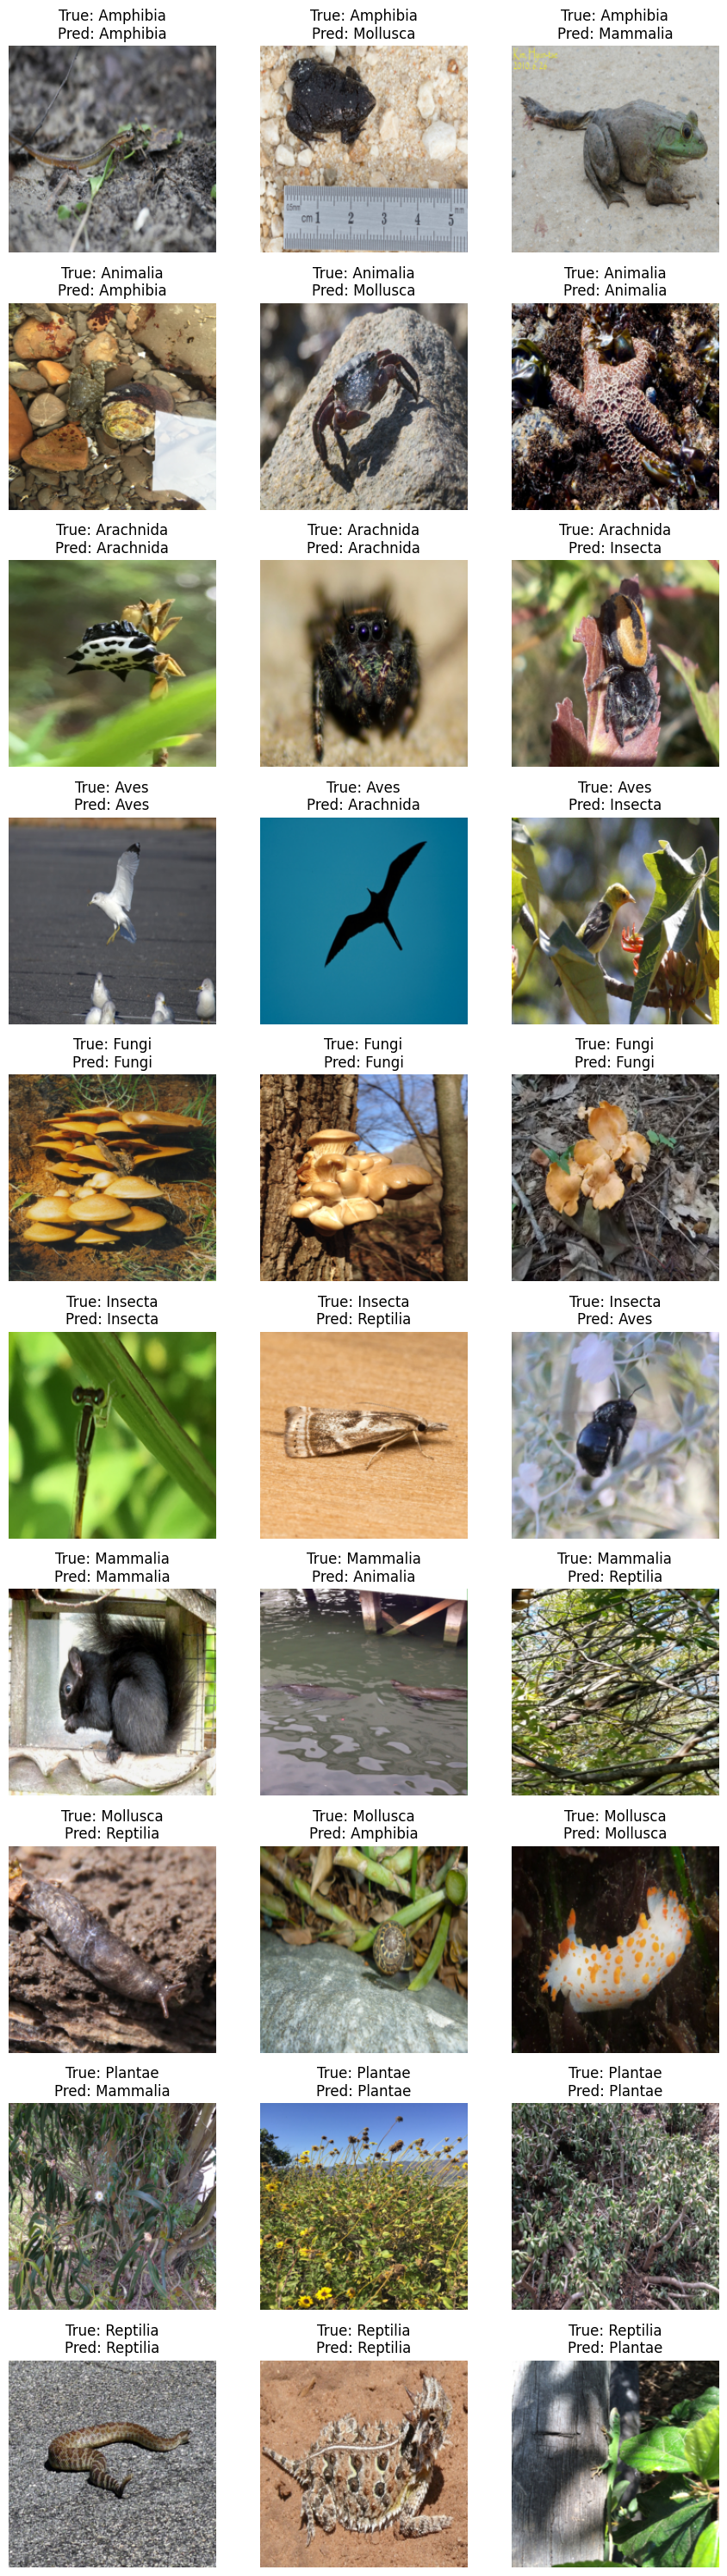

In [11]:
# wandb.login()
wandb.init(project="DA6401-Assignment-2")

input_dim=(400,400)
num_classes=10
train_directory='/kaggle/input/cnndataset1/inaturalist_12K/train'
test_directory='/kaggle/input/cnndataset1/inaturalist_12K/val'

learning_rate = 1e-4 
num_filters = [32, 64, 128, 256, 512]
filter_sizes=[5,5,5,5,5]
activation = "silu"
optimizer_name ="nadam" 
fc_hidden_sizes = [512]
weight_decay = 0.0005
dropout = 0.4
batch_norm =True
batch_size = 32
num_epochs = 10
augmentation=False

data_loader = DataLoaderHelper(
            train_directory,test_directory,
            input_dim,
            batch_size,
            augmentation
        )
train_loader, val_loader,test_loader = data_loader.get_dataloaders()
   
        # Initialize model
model = FlexibleCNN(
    num_filters,
    filter_sizes,
    dropout,
    activation,
    batch_norm,
    input_dim,
    fc_hidden_sizes,
    num_classes=num_classes
)
        
 # Initialize trainer
trainer = Trainer(
    model,
    train_loader,
    val_loader,
    test_loader,
    optimizer_name,
    learning_rate,
    num_epochs,
    weight_decay
)

# Train the model
trainer.train()

trainer.confusion_matrix()
# Log final metrics
for epoch in range(num_epochs):
    wandb.log({
        'train_accuracy': trainer.train_acc_history[epoch]*100,
        'train_loss': trainer.train_loss_history[epoch],
        'val_accuracy': trainer.val_acc_history[epoch]*100,
        'val_loss': trainer.val_loss_history[epoch],
        'epoch' : epoch
    })


wandb.finish()


In [10]:
# !python /kaggle/input/model1/other/default/1/train.py -br "/kaggle/input/cnndataset1/inaturalist_12K"

# !python /kaggle/input/model1/other/default/1/hyper_parameter_tuning.py


Create sweep with ID: spelf3zd
Sweep URL: https://wandb.ai/cs24m042-iit-madras-foundation/DA6401-Assignment-2/sweeps/spelf3zd
wandb: Agent Starting Run: 5uzmz6ch with config:
wandb: 	activation: relu
wandb: 	augmentation: False
wandb: 	batch_norm: False
wandb: 	batch_size: 32
wandb: 	dropout: 0
wandb: 	fc_hidden_sizes: 256
wandb: 	filter_sizes: [5, 3, 5, 3, 5]
wandb: 	learning_rate: 0.0001
wandb: 	num_filters: [128, 128, 64, 64, 32]
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0
wandb: Currently logged in as: cs24m042 (cs24m042-iit-madras-foundation) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
wandb: Tracking run with wandb version 0.19.6
wandb: Run data is saved locally in /kaggle/working/wandb/run-20250418_144922-5uzmz6ch
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run rosy-sweep-1
wandb: ⭐️ View project at https://wandb.ai/cs24m042-iit-madras-foundation/DA6401-Assignment-2
wandb: 🧹 View sweep at https://wandb.ai/cs24m042-iit-madras-fo

In [ ]:
import wandb


from model import FlexibleCNN
from data_loader import DataLoaderHelper
from model_trainer import Trainer

input_dim=(400,400)
num_classes=10

# Add your directory here 
train_directory='/kaggle/input/cnndataset1/inaturalist_12K/train'
test_directory='/kaggle/input/cnndataset1/inaturalist_12K/val'
epochs=10

# Sweep configuration dictionary for wandb
sweep_configuration = {
    'method': 'bayes',
    'name' : 'cnn-hyperparameter-tuning_test',
    'metric': {
      'name': 'val_accuracy',
      'goal': 'maximize'
    },
    'parameters': {
        'num_filters': {
          'values': [[64,128,256,512, 1024], [32,32,32,32,32],[32,64,64,128,128],[128,128,64,64,32],[32,64,128,256,512]]
        },
        'filter_sizes': {
          'values': [[3,3,3,3,3], [5,5,5,5,5], [5,3,5,3,5]]
        },
        'weight_decay': {
            'values':[0, 0.0005, 0.5]
        },
        'augmentation': {
            'values': [True, False]
        },
        'dropout': {
            'values': [0, 0.2, 0.4]
        },
        'learning_rate': {
            'values': [1e-3, 1e-4]
        },
        'activation': {
            'values': ['relu', 'elu', 'selu', 'silu', 'gelu','mish']
        },
        'optimizer': {
            'values': ['nadam', 'adam', 'rmsprop']
        },
        'batch_norm':{
            'values': [True, False]
        },
        'batch_size': {
            'values': [32, 64]
        },
        'fc_hidden_sizes':{
            'values': [128, 256, 512]
        }
    }
}

def train_sweep(config=None):
    with wandb.init(config=config) as run:
        config = wandb.config


        run.name = "optimizer {} activation {} num_filters {} dropout {} filter_sizes {} batch_size {} augmentation {} weight_decay {} batch_norm {} ".format(
            config.optimizer,
            config.activation,
            config.num_filters,
            config.dropout,
            config.filter_sizes,
            config.batch_size,
            config.augmentation,
            config.weight_decay,
            config.batch_norm
          )
        # Initialize data loaders
        data_loader = DataLoaderHelper(
            train_directory,test_data_dir=test_directory,
            input_size=input_dim,
            batch_size=config.batch_size,
            augmentation=config.augmentation
        )
        train_loader, val_loader,test_loader = data_loader.get_dataloaders()
        
        hidden_sizes = [config.fc_hidden_sizes]
        # Initialize model
        model = FlexibleCNN(
            num_filters=config.num_filters,
            filter_sizes=config.filter_sizes,
            dropout=config.dropout,
            activation=config.activation,
            batch_norm=config.batch_norm,
            input_size=input_dim,
            fc_hidden_sizes=hidden_sizes,
            num_classes=num_classes
        )
        
        # Initialize trainer
        trainer = Trainer(
            model=model,
            train_loader=train_loader,
            val_loader=val_loader,
            test_loader=test_loader,
            optimizer_name=config.optimizer,
            learning_rate=config.learning_rate,
            num_epochs=epochs,
            weight_decay=config.weight_decay
        )
        
        # Train the model
        trainer.train()
        
        # Log final metrics
        for epoch in range(epochs):
            wandb.log({
                'train_accuracy': trainer.train_acc_history[epoch]*100,
                'train_loss': trainer.train_loss_history[epoch],
                'val_accuracy': trainer.val_acc_history[epoch]*100,
                'val_loss': trainer.val_loss_history[epoch],
                'epoch' : epoch
            })

if __name__ == "__main__":

    
    sweep_id = wandb.sweep(sweep_configuration, project="DA6401-Assignment-2")

    # Start sweep
    wandb.agent(sweep_id, function=train_sweep, count=1)

In [ ]:
import gc
for i in range(30):
    gc.collect()
    
    torch.cuda.empty_cache() 